Baseado em https://www.kaggle.com/code/raihan150146/traffic-forecasting-using-graph-neural-networks

In [1]:
import pandas as pd
import numpy as np
import os
import typing
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2024-10-01 22:59:52.212751: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-01 22:59:52.232281: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 22:59:52.253791: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 22:59:52.259873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 22:59:52.276240: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Lendo os arquivos CSV usando numpy
route_distances = np.loadtxt("../../data/pemsd7/PeMSD7_W_228.csv", delimiter=",")
speeds_array = np.loadtxt("../../data/pemsd7/PeMSD7_V_228.csv", delimiter=",")

# Exibindo as formas dos arrays carregados
print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(228, 228)
speeds_array shape=(12672, 228)


- O arquivo `PeMSD7_W_228.csv` contém as distâncias entre 228 estações no Distrito 7 da Califórnia.
- O arquivo `PeMSD7_V_228.csv` contém a velocidade do tráfego coletada para essas estações nos dias úteis de maio e junho de 2012.

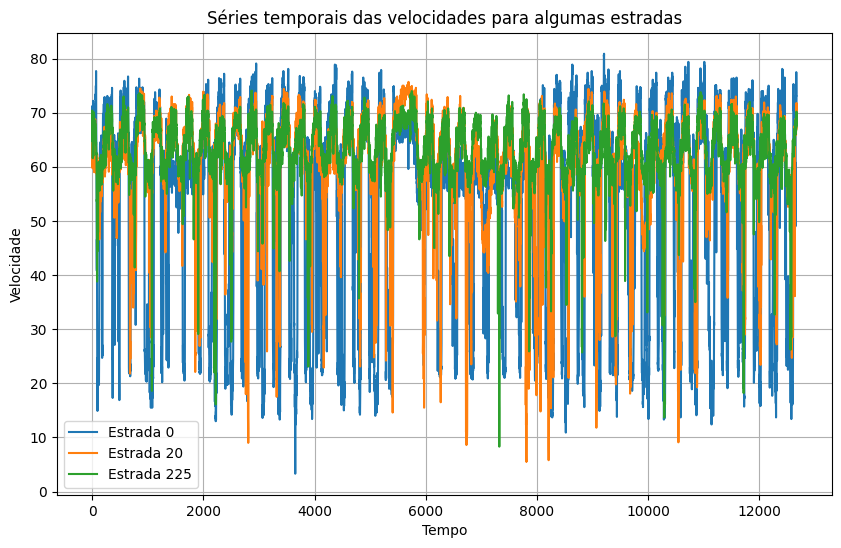

In [3]:
# Selecionar algumas estradas para plotar (por exemplo, estradas 0, 5, 10, 15 e 20)
selected_routes = [0, 20, 225]

# Criar o gráfico das séries temporais das velocidades para as estradas selecionadas
plt.figure(figsize=(10, 6))
for route in selected_routes:
    plt.plot(speeds_array[:, route], label=f'Estrada {route}')

plt.title("Séries temporais das velocidades para algumas estradas")
plt.xlabel("Tempo")
plt.ylabel("Velocidade")
plt.legend()
plt.grid(True)
plt.show()

Para reduzir o tamanho do problema e tornar o treinamento mais rápido, vamos trabalhar apenas com uma amostra de 26 estradas das 228 estradas presentes no conjunto de dados. Escolhemos as estradas começando pela estrada 0, selecionando as 5 estradas mais próximas a ela e continuando esse processo até obtermos 25 estradas. Você pode escolher qualquer outro subconjunto de estradas. Escolhemos as estradas dessa maneira para aumentar a probabilidade de termos estradas com séries temporais de velocidade correlacionadas. sample_routes contém os IDs das estradas selecionadas.

In [4]:
sample_routes = [
    0,
    1,
    4,
    7,
    8,
    11,
    15,
    108,
    109,
    114,
    115,
    118,
    120,
    123,
    124,
    126,
    127,
    129,
    130,
    132,
    133,
    136,
    139,
    144,
    147,
    216,
]
route_distances = route_distances[np.ix_(sample_routes, sample_routes)] 
speeds_array = speeds_array[:, sample_routes]

print(f"route_distances shape={route_distances.shape}")
print(f"speeds_array shape={speeds_array.shape}")

route_distances shape=(26, 26)
speeds_array shape=(12672, 26)


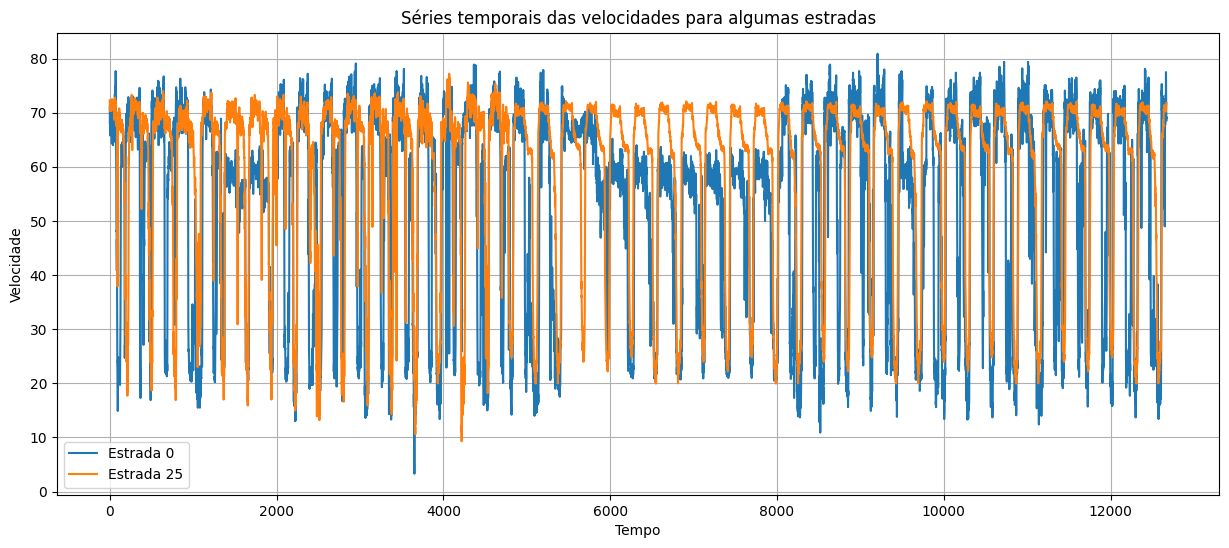

In [5]:
# Selecionar algumas estradas para plotar (por exemplo, estradas 0, 5, 10, 15 e 20)
selected_routes = [0, 25]

# Criar o gráfico das séries temporais das velocidades para as estradas selecionadas
plt.figure(figsize=(15, 6))
for route in selected_routes:
    plt.plot(speeds_array[:, route], label=f'Estrada {route}')

plt.title("Séries temporais das velocidades para algumas estradas")
plt.xlabel("Tempo")
plt.ylabel("Velocidade")
plt.legend()
plt.grid(True)
plt.show()

<Figure size 1500x1500 with 0 Axes>

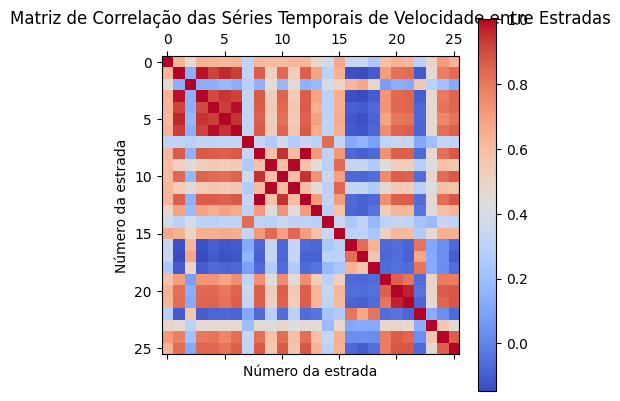

In [6]:
# Criar o gráfico de matriz de correlação com legenda
plt.figure(figsize=(15, 15))
corr_matrix = np.corrcoef(speeds_array.T)

# Plot da matriz de correlação
cax = plt.matshow(corr_matrix, cmap='coolwarm')

# Adicionar barra de cores (legenda)
plt.colorbar(cax)

# Definir rótulos para os eixos
plt.xlabel("Número da estrada")
plt.ylabel("Número da estrada")

plt.title("Matriz de Correlação das Séries Temporais de Velocidade entre Estradas")
plt.show()


## Separando em treino, calibração e teste

In [7]:
train_size, val_size = 0.5, 0.2


def preprocess(data_array: np.ndarray, train_size: float, val_size: float):
    """Splits data into train/val/test sets and normalizes the data.

    Args:
        data_array: ndarray of shape `(num_time_steps, num_routes)`
        train_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the train split.
        val_size: A float value between 0.0 and 1.0 that represent the proportion of the dataset
            to include in the validation split.

    Returns:
        `train_array`, `val_array`, `test_array`
    """

    num_time_steps = data_array.shape[0]
    num_train, num_val = (
        int(num_time_steps * train_size),
        int(num_time_steps * val_size),
    )
    train_array = data_array[:num_train]
    mean, std = train_array.mean(axis=0), train_array.std(axis=0)

    train_array = (train_array - mean) / std
    val_array = (data_array[num_train : (num_train + num_val)] - mean) / std
    test_array = (data_array[(num_train + num_val) :] - mean) / std

    return train_array, val_array, test_array


train_array, val_array, test_array = preprocess(speeds_array, train_size, val_size)

print(f"train set size: {train_array.shape}")
print(f"validation set size: {val_array.shape}")
print(f"test set size: {test_array.shape}")

train set size: (6336, 26)
validation set size: (2534, 26)
test set size: (3802, 26)


## Criação dos Conjuntos de Dados para o Problema de Previsão

O problema de previsão pode ser enunciado da seguinte forma: dada uma sequência dos valores de velocidade das estradas nos tempos $t+1$, $t+2$, ..., $t+T$, queremos prever os valores futuros da velocidade das estradas para os tempos $t+T+1$, ..., $t+T+h$. Portanto, para cada tempo $t$, as entradas para o nosso modelo são $T$ vetores de tamanho $N$, e os alvos são $h$ vetores de tamanho $N$, onde $N$ é o número de estradas.

Usamos a função timeseries_dataset_from_array() embutida no Keras. A função create_tf_dataset() abaixo recebe como entrada um numpy.ndarray e retorna um tf.data.Dataset. Nesta função, input_sequence_length=T e forecast_horizon=h.

O argumento multi_horizon precisa de mais explicações. Suponha que forecast_horizon=3. Se multi_horizon=True, o modelo fará uma previsão para os passos de tempo $t+T+1$, $t+T+2$, $t+T+3$. Portanto, o alvo terá a forma $(T,3)$. Mas, se multi_horizon=False, o modelo fará uma previsão apenas para o passo de tempo $t+T+3$ e, assim, o alvo terá a forma $(T, 1)$.

Você pode notar que o tensor de entrada em cada lote tem a forma (batch_size, input_sequence_length, num_routes, 1). A última dimensão é adicionada para tornar o modelo mais geral: em cada passo de tempo, as características de entrada para cada estrada podem conter várias séries temporais. Por exemplo, pode-se querer usar séries temporais de temperatura, além dos valores históricos da velocidade, como características de entrada. Neste exemplo, no entanto, a última dimensão da entrada é sempre 1.

Usamos os últimos 12 valores da velocidade em cada estrada para prever a velocidade para 3 passos à frente:

In [8]:
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 64
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 128,
    shuffle=True,
    multi_horizon=True,
):
    """Creates tensorflow dataset from numpy array.

    This function creates a dataset where each element is a tuple `(inputs, targets)`.
    `inputs` is a Tensor
    of shape `(batch_size, input_sequence_length, num_routes, 1)` containing
    the `input_sequence_length` past values of the timeseries for each node.
    `targets` is a Tensor of shape `(batch_size, forecast_horizon, num_routes)`
    containing the `forecast_horizon`
    future values of the timeseries for each node.

    Args:
        data_array: np.ndarray with shape `(num_time_steps, num_routes)`
        input_sequence_length: Length of the input sequence (in number of timesteps).
        forecast_horizon: If `multi_horizon=True`, the target will be the values of the timeseries for 1 to
            `forecast_horizon` timesteps ahead. If `multi_horizon=False`, the target will be the value of the
            timeseries `forecast_horizon` steps ahead (only one value).
        batch_size: Number of timeseries samples in each batch.
        shuffle: Whether to shuffle output samples, or instead draw them in chronological order.
        multi_horizon: See `forecast_horizon`.

    Returns:
        A tf.data.Dataset instance.
    """

    inputs = timeseries_dataset_from_array(
        np.expand_dims(data_array[:-forecast_horizon], axis=-1),
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1
    targets = timeseries_dataset_from_array(
        data_array[target_offset:],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(100)

    return dataset.prefetch(16).cache()


train_dataset, val_dataset = (
    create_tf_dataset(data_array, input_sequence_length, forecast_horizon, batch_size)
    for data_array in [train_array, val_array]
)

test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)

## Exibindo alguns exemplos dos dados do dataset

2024-10-01 22:59:56.187637: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-10-01 22:59:56.188621: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


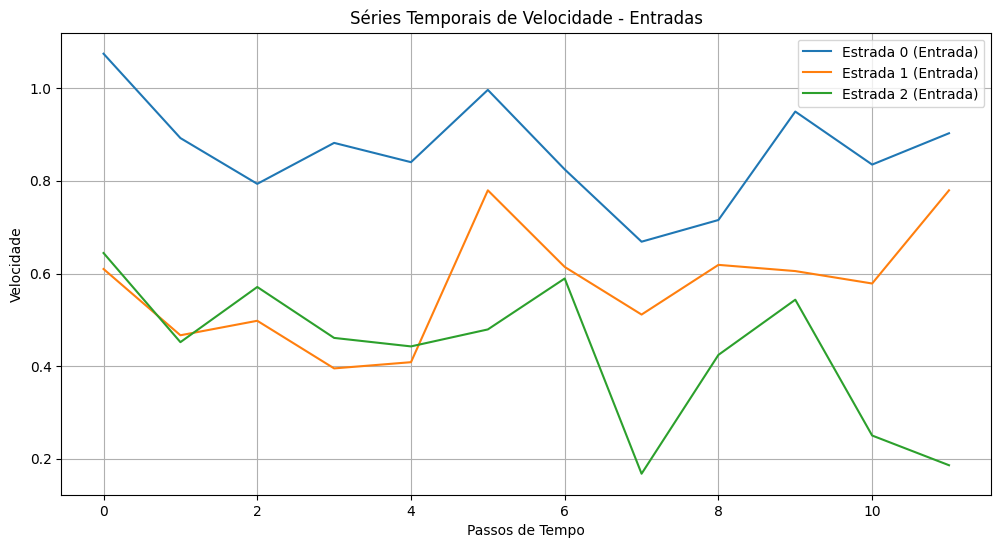

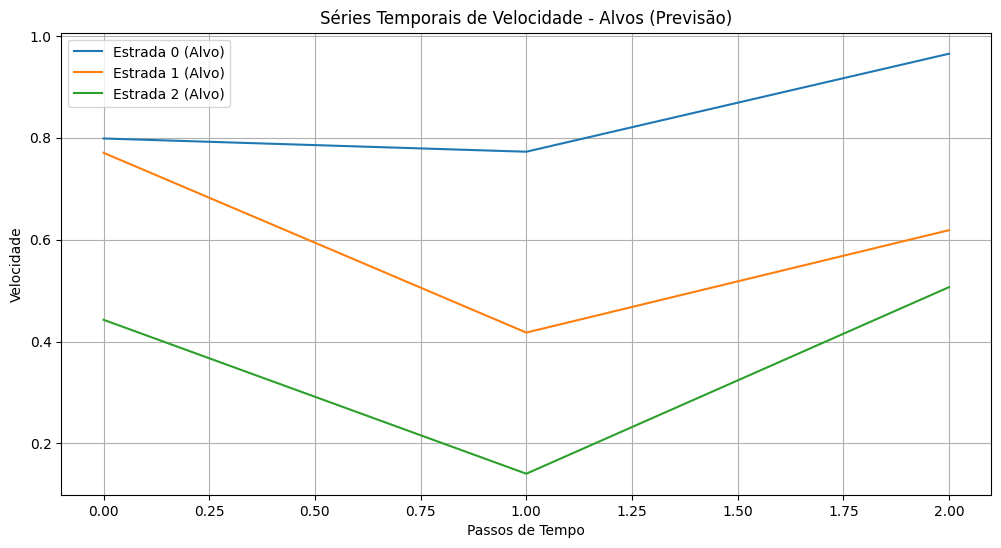

In [9]:
for batch_inputs, batch_targets in train_dataset.take(1):
    batch_inputs = batch_inputs.numpy()
    batch_targets = batch_targets.numpy()

# Selecionar algumas estradas e exibir suas séries temporais
selected_routes = [0, 1, 2]  # Escolhendo três rotas como exemplo

plt.figure(figsize=(12, 6))
for route in selected_routes:
    plt.plot(batch_inputs[0, :, route, 0], label=f'Estrada {route} (Entrada)')

plt.title("Séries Temporais de Velocidade - Entradas")
plt.xlabel("Passos de Tempo")
plt.ylabel("Velocidade")
plt.legend()
plt.grid(True)
plt.show()

# Plotar as previsões (targets)
plt.figure(figsize=(12, 6))
for route in selected_routes:
    plt.plot(batch_targets[0, :, route], label=f'Estrada {route} (Alvo)')

plt.title("Séries Temporais de Velocidade - Alvos (Previsão)")
plt.xlabel("Passos de Tempo")
plt.ylabel("Velocidade")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
def compute_adjacency_matrix(
    route_distances: np.ndarray, sigma2: float, epsilon: float
):
    """Computes the adjacency matrix from distances matrix.

    It uses the formula in https://github.com/VeritasYin/STGCN_IJCAI-18#data-preprocessing to
    compute an adjacency matrix from the distance matrix.
    The implementation follows that paper.

    Args:
        route_distances: np.ndarray of shape `(num_routes, num_routes)`. Entry `i,j` of this array is the
            distance between roads `i,j`.
        sigma2: Determines the width of the Gaussian kernel applied to the square distances matrix.
        epsilon: A threshold specifying if there is an edge between two nodes. Specifically, `A[i,j]=1`
            if `np.exp(-w2[i,j] / sigma2) >= epsilon` and `A[i,j]=0` otherwise, where `A` is the adjacency
            matrix and `w2=route_distances * route_distances`

    Returns:
        A boolean graph adjacency matrix.
    """
    num_routes = route_distances.shape[0]
    route_distances = route_distances / 10000.0
    w2, w_mask = (
        route_distances * route_distances,
        np.ones([num_routes, num_routes]) - np.identity(num_routes),
    )
    return (np.exp(-w2 / sigma2) >= epsilon) * w_mask

In [11]:
class GraphInfo:
    def __init__(self, edges: typing.Tuple[list, list], num_nodes: int):
        self.edges = edges
        self.num_nodes = num_nodes


sigma2 = 0.1
epsilon = 0.5
adjacency_matrix = compute_adjacency_matrix(route_distances, sigma2, epsilon)
node_indices, neighbor_indices = np.where(adjacency_matrix == 1)
graph = GraphInfo(
    edges=(node_indices.tolist(), neighbor_indices.tolist()),
    num_nodes=adjacency_matrix.shape[0],
)
print(f"number of nodes: {graph.num_nodes}, number of edges: {len(graph.edges[0])}")



number of nodes: 26, number of edges: 150


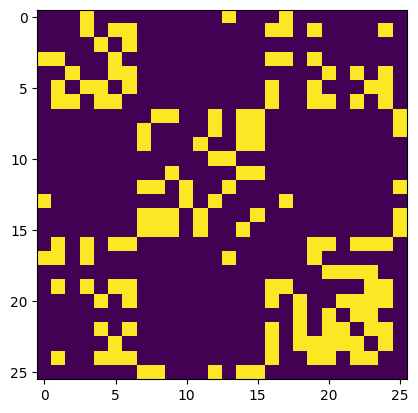

In [13]:
plt.imshow(adjacency_matrix)

In [14]:
adjacency_matrix.sum()

150.0

In [15]:
class GraphConv(layers.Layer):
    def __init__(
        self,
        in_feat,
        out_feat,
        graph_info: GraphInfo,
        aggregation_type="mean",
        combination_type="concat",
        activation: typing.Optional[str] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.graph_info = graph_info
        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.weight = tf.Variable(
            initial_value=keras.initializers.glorot_uniform()(
                shape=(in_feat, out_feat), dtype="float32"
            ),
            trainable=True,
        )
        self.activation = layers.Activation(activation)

    def aggregate(self, neighbour_representations: tf.Tensor):
        aggregation_func = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_type)

        if aggregation_func:
            return aggregation_func(
                neighbour_representations,
                self.graph_info.edges[0],
                num_segments=self.graph_info.num_nodes,
            )

        raise ValueError(f"Invalid aggregation type: {self.aggregation_type}")

    def compute_nodes_representation(self, features: tf.Tensor):
        """Computes each node's representation.

        The nodes' representations are obtained by multiplying the features tensor with
        `self.weight`. Note that
        `self.weight` has shape `(in_feat, out_feat)`.

        Args:
            features: Tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        return tf.matmul(features, self.weight)

    def compute_aggregated_messages(self, features: tf.Tensor):
        neighbour_representations = tf.gather(features, self.graph_info.edges[1])
        aggregated_messages = self.aggregate(neighbour_representations)
        return tf.matmul(aggregated_messages, self.weight)

    def update(self, nodes_representation: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combination_type == "concat":
            h = tf.concat([nodes_representation, aggregated_messages], axis=-1)
        elif self.combination_type == "add":
            h = nodes_representation + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        return self.activation(h)

    def call(self, features: tf.Tensor):
        """Forward pass.

        Args:
            features: tensor of shape `(num_nodes, batch_size, input_seq_len, in_feat)`

        Returns:
            A tensor of shape `(num_nodes, batch_size, input_seq_len, out_feat)`
        """
        nodes_representation = self.compute_nodes_representation(features)
        aggregated_messages = self.compute_aggregated_messages(features)
        return self.update(nodes_representation, aggregated_messages)

In [16]:
class LSTMGC(layers.Layer):
    """Layer comprising a convolution layer followed by LSTM and dense layers."""

    def __init__(
        self,
        in_feat,
        out_feat,
        lstm_units: int,
        input_seq_len: int,
        output_seq_len: int,
        graph_info: GraphInfo,
        graph_conv_params: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # graph conv layer
        if graph_conv_params is None:
            graph_conv_params = {
                "aggregation_type": "mean",
                "combination_type": "concat",
                "activation": None,
            }
        self.graph_conv = GraphConv(in_feat, out_feat, graph_info, **graph_conv_params)

        self.lstm = layers.LSTM(lstm_units, activation="relu")
        self.dense = layers.Dense(output_seq_len)

        self.input_seq_len, self.output_seq_len = input_seq_len, output_seq_len

    def call(self, inputs):
        """Forward pass.

        Args:
            inputs: tf.Tensor of shape `(batch_size, input_seq_len, num_nodes, in_feat)`

        Returns:
            A tensor of shape `(batch_size, output_seq_len, num_nodes)`.
        """

        # convert shape to  (num_nodes, batch_size, input_seq_len, in_feat)
        inputs = tf.transpose(inputs, [2, 0, 1, 3])

        gcn_out = self.graph_conv(
            inputs
        )  # gcn_out has shape: (num_nodes, batch_size, input_seq_len, out_feat)
        shape = tf.shape(gcn_out)
        num_nodes, batch_size, input_seq_len, out_feat = (
            shape[0],
            shape[1],
            shape[2],
            shape[3],
        )

        # LSTM takes only 3D tensors as input
        gcn_out = tf.reshape(gcn_out, (batch_size * num_nodes, input_seq_len, out_feat))
        lstm_out = self.lstm(
            gcn_out
        )  # lstm_out has shape: (batch_size * num_nodes, lstm_units)

        dense_output = self.dense(
            lstm_out
        )  # dense_output has shape: (batch_size * num_nodes, output_seq_len)
        output = tf.reshape(dense_output, (num_nodes, batch_size, self.output_seq_len))
        return tf.transpose(
            output, [1, 2, 0]
        )  # returns Tensor of shape (batch_size, output_seq_len, num_nodes)

In [17]:
in_feat = 1
batch_size = 64
epochs = 20
input_sequence_length = 12
forecast_horizon = 3
multi_horizon = False
out_feat = 10
lstm_units = 64
graph_conv_params = {
    "aggregation_type": "mean",
    "combination_type": "concat",
    "activation": None,
}

st_gcn = LSTMGC(
    in_feat,
    out_feat,
    lstm_units,
    input_sequence_length,
    forecast_horizon,
    graph,
    graph_conv_params,
)
inputs = layers.Input((input_sequence_length, graph.num_nodes, in_feat))
outputs = st_gcn(inputs)

model = keras.models.Model(inputs, outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.0002),
    loss=keras.losses.MeanSquaredError(),
)
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
)

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 0.7292 - val_loss: 0.2482
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - loss: 0.2338 - val_loss: 0.1588
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 0.1542 - val_loss: 0.1117
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 7s 67ms/step - loss: 0.1144 - val_loss: 0.0936
Epoch 5/20
79/99 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0981

KeyboardInterrupt: 

119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step
naive MAE: 0.13472308593195767, model MAE: 0.14242310602164246


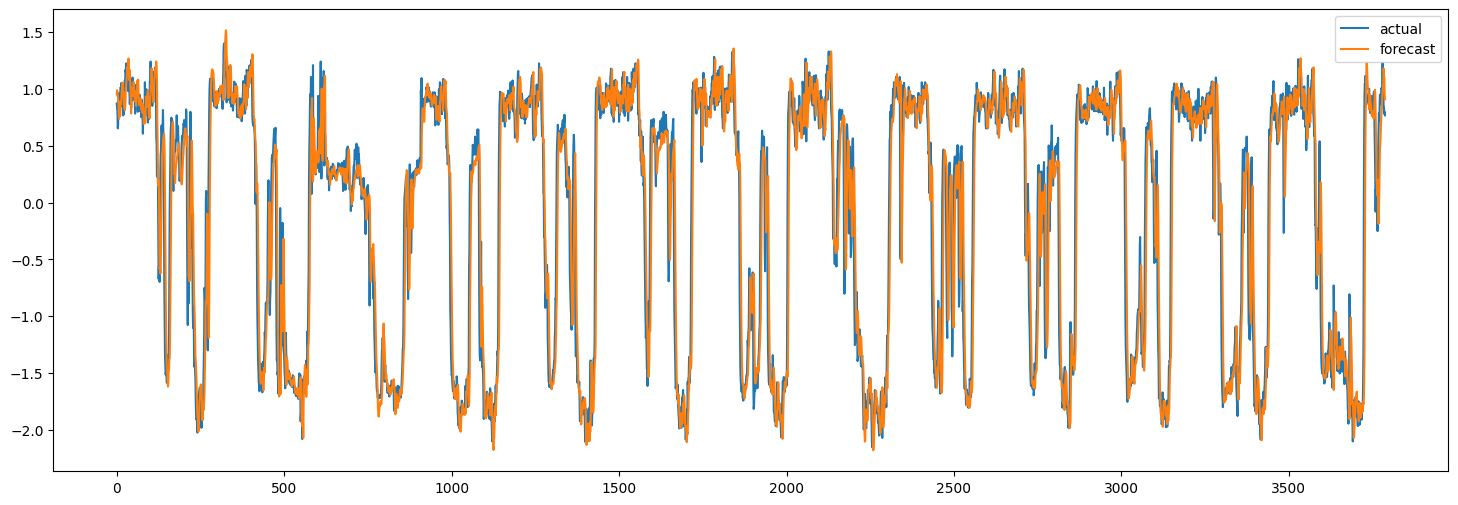

In [18]:
x_test, y = next(test_dataset.as_numpy_iterator())
y_pred = model.predict(x_test)
plt.figure(figsize=(18, 6))
plt.plot(y[:, 0, 0])
plt.plot(y_pred[:, 0, 0])
plt.legend(["actual", "forecast"])

naive_mse, model_mse = (
    np.square(x_test[:, -1, :, 0] - y[:, 0, :]).mean(),
    np.square(y_pred[:, 0, :] - y[:, 0, :]).mean(),
)
print(f"naive MAE: {naive_mse}, model MAE: {model_mse}")